## Задание

1. Прочитайте базу my_PJME_MW.csv и сделайте ее перерасчет (ресемплинг) в представление по неделям.

2. Постройте модель предсказания 4-й точки от текущей (h = 4), используя результаты автокорреляционного анализа из предшествующих уроков .
3. Постройте модель предсказания 1-й точки от текущей (h = 1), используя результаты автокорреляционного анализа из предшествующих уроков.
4. Примените авторекурсию и сравните результат в 4-й точке путем прямого моделирования и путем рекурсивного моделирования на длине выборки из 4-х точек. 
5. Оцените рост ошибки прогнозирования рекурсивной модели в интервалах от 1-й до 10-й, от 10-й до 20-й, от 20-й до 30-й, .. .10*i-й до (i+1)*10 -й,... ,от 90 до 100-й точках (используйте осреднение по десяткам точек)

6. Сделайте вывод о том, как изменилось поведение ошибки предсказания ряда.

In [425]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd 
import seaborn as sns
import statsmodels.api as sm

In [426]:
data = pd.read_csv('my_PJME_MW.csv', index_col=[0], parse_dates=[0])

In [427]:
data_per_week = data.copy().resample('W').mean()
data_per_week.head(10)

,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,
2002-01-06,32392.160839,2002.0,1.000000,3.517483,1.0,3.517483,1.0,3.517483,11.58042,0.160839,0.000000,0.167832
2002-01-13,31487.386905,2002.0,1.000000,10.000000,1.0,10.000000,2.0,3.000000,11.50000,0.000000,0.000000,0.000000
2002-01-20,31452.880952,2002.0,1.000000,17.000000,1.0,17.000000,3.0,3.000000,11.50000,0.000000,0.142857,0.000000
2002-01-27,30141.529762,2002.0,1.000000,24.000000,1.0,24.000000,4.0,3.000000,11.50000,0.142857,0.000000,0.142857
2002-02-03,29196.488095,2002.0,1.428571,17.714286,1.0,31.000000,5.0,3.000000,11.50000,0.000000,0.000000,0.000000
2002-02-10,31150.517857,2002.0,2.000000,7.000000,1.0,38.000000,6.0,3.000000,11.50000,0.000000,0.000000,0.000000
2002-02-17,30616.565476,2002.0,2.000000,14.000000,1.0,45.000000,7.0,3.000000,11.50000,0.000000,0.142857,0.000000
2002-02-24,29144.130952,2002.0,2.000000,21.000000,1.0,52.000000,8.0,3.000000,11.50000,0.142857,0.000000,0.142857
2002-03-03,29869.011905,2002.0,2.428571,16.000000,1.0,59.000000,9.0,3.000000,11.50000,0.000000,0.000000,0.000000


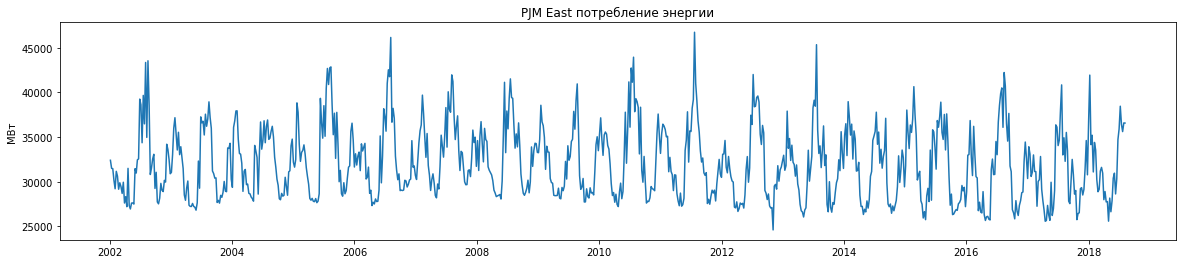

In [428]:
plt.figure(figsize=(20,4))
plt.plot(data_per_week.index, data_per_week['PJME_MW'])
plt.title('PJM East потребление энергии' )
plt.ylabel('МВт' )
plt.show()

Удалим данные которые потеряли акульаность, такие как часы, день месяца, день года, день недели, месяц(т.к. неделя может входить в два месяца)... данные по кварталам оставим, т.к. неделя реже входит сразу в 2 квартала, поэтому оставим и в дальнейшем округлим до целого.

In [429]:
data_per_week.drop(['hour', 'dayofmonth', 'dayofyear', 'dayofweek', 'month', 'is_prev_holiday', 'is_next_holiday', 'year'], axis=1,inplace=True)

In [ ]:
data_per_week.quarter = np.around(data_per_week.quarter.values)

Если на неделе был праздник, будем считать неделю праздничной(прям как рабочие выходные по всей России)

In [431]:
data_per_week.loc[data_per_week.is_holiday>0, 'is_holiday'] = 1

In [432]:
data_per_week.head(10)

,PJME_MW,quarter,weekofyear,is_holiday
Date,,,,
2002-01-06,32392.160839,1.0,1.0,1.0
2002-01-13,31487.386905,1.0,2.0,0.0
2002-01-20,31452.880952,1.0,3.0,0.0
2002-01-27,30141.529762,1.0,4.0,1.0
2002-02-03,29196.488095,1.0,5.0,0.0
2002-02-10,31150.517857,1.0,6.0,0.0
2002-02-17,30616.565476,1.0,7.0,0.0
2002-02-24,29144.130952,1.0,8.0,1.0
2002-03-03,29869.011905,1.0,9.0,0.0


In [433]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import seaborn as sns

scl=StandardScaler()
tsne_ =TSNE(n_components=2)

X = data_per_week.values

Xscale = scl.fit_transform(X)
X_t = tsne_.fit_transform(Xscale)

In [434]:
X_t

array([[-30.210093 ,  18.751804 ],
       [-45.383003 , -10.155499 ],
       [-45.85867  , -10.071012 ],
       ...,
       [  3.788118 ,   8.531882 ],
       [  3.4716027,  11.026661 ],
       [  3.918095 ,  11.249497 ]], dtype=float32)

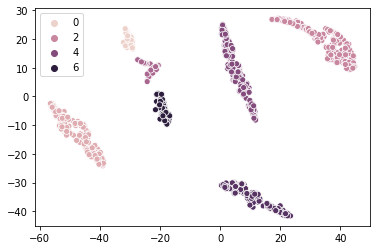

In [435]:
clast_0 = DBSCAN(eps=3, leaf_size=15)
clast_1 = DBSCAN(eps=3, leaf_size=15)
X_clast =clast_0.fit_predict(X_t)
X_scale_clast =clast_1.fit_predict(Xscale)

sns.scatterplot(X_t[:,0],X_t[:,1], hue=X_clast)
plt.show()

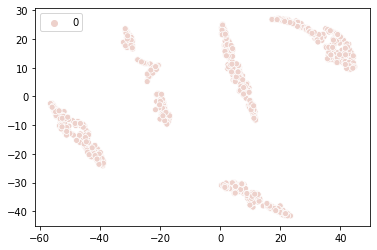

In [436]:
sns.scatterplot(X_t[:,0],X_t[:,1], hue=X_scale_clast)
plt.show()

In [437]:
print('Число кластеров в календаре с масштабированием: ',len(np.unique(X_scale_clast)))
print('Число кластеров в календаре: ',len(np.unique(X_clast)))

Число кластеров в календаре с масштабированием:  1
Число кластеров в календаре:  7


Число кластеров для только скалированных данных равно 1, не годится

Выбираем кластеры для масштабированных данных с понижением размерности.

In [438]:
data_per_week['claster_week'] = X_clast
data_per_week.iloc[np.where(data_per_week['claster_week']==0)[0]].iloc[:10,:]

,PJME_MW,quarter,weekofyear,is_holiday,claster_week
Date,,,,,
2002-01-06,32392.160839,1.0,1.0,1.0,0
2002-01-27,30141.529762,1.0,4.0,1.0,0
2002-02-24,29144.130952,1.0,8.0,1.0,0
2003-01-05,31034.410714,2.0,1.0,1.0,0
2003-01-26,37169.547619,1.0,4.0,1.0,0
2003-02-23,33023.458333,1.0,8.0,1.0,0
2004-01-04,29353.732143,2.0,1.0,1.0,0
2004-01-25,37925.613095,1.0,4.0,1.0,0
2004-02-22,33083.369048,1.0,8.0,1.0,0


In [439]:
data_per_week.iloc[np.where(data_per_week['claster_week']==2)[0]].iloc[:10,:]

,PJME_MW,quarter,weekofyear,is_holiday,claster_week
Date,,,,,
2002-04-07,28308.778443,2.0,14.0,0.0,2
2002-04-14,27182.482143,2.0,15.0,0.0,2
2002-04-21,31484.488095,2.0,16.0,0.0,2
2002-04-28,27316.886905,2.0,17.0,0.0,2
2002-05-05,26929.482143,2.0,18.0,0.0,2
2002-05-12,27587.095238,2.0,19.0,0.0,2
2002-05-19,27606.833333,2.0,20.0,0.0,2
2002-05-26,27480.416667,2.0,21.0,0.0,2
2002-06-09,30961.797619,2.0,23.0,0.0,2


In [440]:
from sklearn.decomposition import PCA

pca = PCA(n_components=4, svd_solver='full')
Xpca = pca.fit(Xscale[:,:])
Xpca = pca.transform(Xscale[:,:])
pca.explained_variance_ratio_

array([0.49818088, 0.25377141, 0.23812062, 0.00992709])

Сам по себе PCA показал не очень важный результат, но возьмем первые 3 компоненты.

In [441]:
data_per_week['pca1']=Xpca[:,0]
data_per_week['pca2']=Xpca[:,1]
data_per_week['pca3']=Xpca[:,2]

Первые разности

In [442]:
data_per_week['diff1'] = data_per_week.PJME_MW.diff()

Разности второго порядка

In [443]:
data_per_week['diff2'] = data_per_week.PJME_MW.diff(periods=2)

In [444]:
data_per_week = data_per_week.iloc[2:,:]

Отношение первых разностей к основным данным

In [445]:
data_per_week['diff1_d'] = data_per_week.diff1/data_per_week.PJME_MW

Логарифм данных

In [446]:
data_per_week['diff1_l'] = np.log(data_per_week.PJME_MW.values)

Разница со средним значанием по номеру недели в году по всей выборке 

In [447]:
data_per_week['diff_week_mean'] = 0
for number_week in data_per_week.weekofyear.unique():
    mean_for_week = data_per_week.loc[data_per_week.weekofyear==number_week, 'PJME_MW'].values.mean()
    data_per_week.loc[data_per_week.weekofyear==number_week, 'diff_week_mean'] = \
    data_per_week.loc[data_per_week.weekofyear==number_week, 'PJME_MW']-mean_for_week

Разница со средним значанием по номеру квартала в году по всей выборке 

In [448]:
data_per_week['diff_qarter_mean'] = 0
for number_quarter in data_per_week.quarter.unique():
    mean_for_quarter = data_per_week.loc[data_per_week.quarter==number_quarter, 'PJME_MW'].values.mean()
    data_per_week.loc[data_per_week.quarter==number_quarter, 'diff_qarter_mean'] = \
    data_per_week.loc[data_per_week.quarter==number_quarter, 'PJME_MW']-mean_for_quarter

In [449]:
data_per_week.head()

,PJME_MW,quarter,weekofyear,is_holiday,claster_week,pca1,pca2,pca3,diff1,diff2,diff1_d,diff1_l,diff_week_mean,diff_qarter_mean
Date,,,,,,,,,,,,,,
2002-01-20,31452.880952,1.0,3.0,0.0,1,-2.063455,-0.392754,-0.092300,-34.505952,-939.279887,-0.001097,10.356246,-3291.383053,-1289.251190
2002-01-27,30141.529762,1.0,4.0,1.0,0,-1.609578,0.965190,-2.222886,-1311.351190,-1345.857143,-0.043506,10.313659,-4779.723039,-2600.602381
2002-02-03,29196.488095,1.0,5.0,0.0,1,-1.915057,-0.833560,-0.429627,-945.041667,-2256.392857,-0.032368,10.281804,-5022.566527,-3545.644047
2002-02-10,31150.517857,1.0,6.0,0.0,1,-1.917127,-0.455161,-0.113180,1954.029762,1008.988095,0.062729,10.346586,-3116.772409,-1591.614285
2002-02-17,30616.565476,1.0,7.0,0.0,1,-1.857633,-0.560117,-0.188315,-533.952381,1420.077381,-0.017440,10.329296,-2783.392157,-2125.566666


Добавим скользящее среднее по всей модели с глубиной 13 недель.

In [497]:
data_per_week['d_w13']=data_per_week['PJME_MW'].rolling(window=13).mean()

Добавим экспоненциальное среднее с различными альфа.

In [451]:
def exponential_smoothing(series, alpha):
    result = [series[0]] 
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

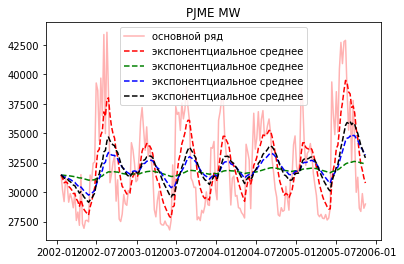

In [452]:
data_per_week['exp_0_01'] = exponential_smoothing(data_per_week['PJME_MW'], 0.01)
data_per_week['exp_0_03'] = exponential_smoothing(data_per_week['PJME_MW'], 0.03)
data_per_week['exp_0_04'] = exponential_smoothing(data_per_week['PJME_MW'], 0.04)
data_per_week['exp_0_05'] = exponential_smoothing(data_per_week['PJME_MW'], 0.05)
data_per_week['exp_0_06'] = exponential_smoothing(data_per_week['PJME_MW'], 0.06)
data_per_week['exp_0_07'] = exponential_smoothing(data_per_week['PJME_MW'], 0.07)
data_per_week['exp_0_08'] = exponential_smoothing(data_per_week['PJME_MW'], 0.08)
data_per_week['exp_0_1'] = exponential_smoothing(data_per_week['PJME_MW'], 0.1)
data_per_week['exp_0_2'] = exponential_smoothing(data_per_week['PJME_MW'], 0.2)

N100=200
plt.plot(data_per_week.index[:N100],data_per_week['PJME_MW'][:N100],'r',label ='основной ряд',alpha=0.3)
plt.plot(data_per_week.index[:N100],data_per_week['exp_0_2'][:N100],'--r',label ='экспонентциальное среднее')
plt.plot(data_per_week.index[:N100],data_per_week['exp_0_01'][:N100],'--g',label ='экспонентциальное среднее')
plt.plot(data_per_week.index[:N100],data_per_week['exp_0_05'][:N100],'--b',label ='экспонентциальное среднее')
plt.plot(data_per_week.index[:N100],data_per_week['exp_0_08'][:N100],'--k',label ='экспонентциальное среднее')
plt.legend()
plt.title('PJME MW')
plt.show()

In [453]:
data_per_week.iloc[10:15,:]

,PJME_MW,quarter,weekofyear,is_holiday,claster_week,pca1,pca2,pca3,diff1,diff2,...,d_w7,exp_0_01,exp_0_03,exp_0_04,exp_0_05,exp_0_06,exp_0_07,exp_0_08,exp_0_1,exp_0_2
Date,,,,,,,,,,,,,,,,,,,,,
2002-03-31,27595.869048,1.0,13.0,0.0,1,-1.505195,-1.154296,-0.610323,-2331.619048,-1076.910714,...,29323.822279,31271.776849,30946.487086,30800.517982,30664.577803,30537.920385,30419.851458,30309.725414,30110.944639,29427.037877
2002-04-07,28308.778443,2.0,14.0,0.0,2,-0.846261,-1.022822,-0.384569,712.909395,-1618.709652,...,28994.138417,31242.146865,30867.355826,30700.848400,30546.787835,30404.171868,30272.076347,30149.649657,29930.728019,29203.385990
2002-04-14,27182.482143,2.0,15.0,0.0,2,-0.772109,-1.242856,-0.552933,-1126.296300,-413.386905,...,28713.902873,31201.550218,30756.809616,30560.113750,30378.572550,30210.870485,30055.804753,29912.276256,29655.903432,28799.205221
2002-04-21,31484.488095,2.0,16.0,0.0,2,-0.832280,-0.408302,0.133061,4302.005952,3175.709652,...,28944.685186,31204.379597,30778.639970,30597.088724,30433.868327,30287.287541,30155.812587,30038.053203,29838.761898,29336.261796
2002-04-28,27316.886905,2.0,17.0,0.0,2,-0.682871,-1.219188,-0.513973,-4167.601190,134.404762,...,28641.253213,31165.504670,30674.787378,30465.880651,30278.019256,30109.063503,29957.087789,29820.359899,29586.574399,28932.386817


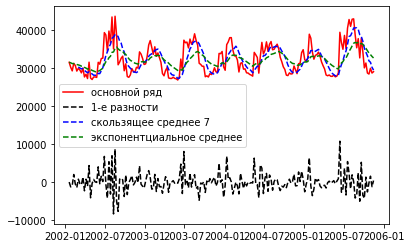

In [454]:
N100=200
plt.plot(data_per_week.index[:N100],data_per_week['PJME_MW'][:N100],'r',label ='основной ряд')
plt.plot(data_per_week.index[:N100],data_per_week['diff1'][:N100],'--k',label ='1-е разности')
plt.plot(data_per_week.index[:N100],data_per_week['d_w7'][:N100],'--b',label ='скользящее среднее 7')
plt.plot(data_per_week.index[:N100],data_per_week['exp_0_1'][:N100],'--g',label ='экспонентциальное среднее')
plt.legend()
plt.show()

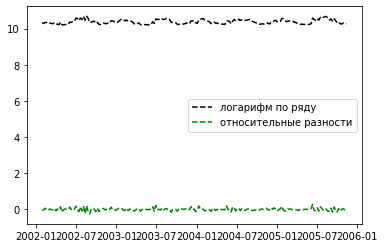

In [455]:
N100=200
plt.plot(data_per_week.index[1:N100],data_per_week['diff1_l'][1:N100],'--k',label ='логарифм по ряду')
plt.plot(data_per_week.index[1:N100],data_per_week['diff1_d'][1:N100],'--g',label ='относительные разности')
plt.legend()
plt.show()

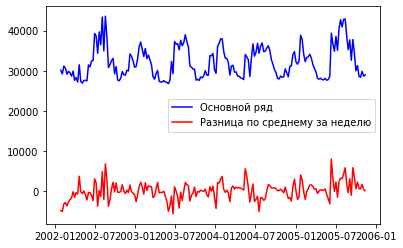

In [456]:
N100=200
plt.plot(data_per_week.index[1:N100],data_per_week['PJME_MW'][1:N100],'-b',label ='Основной ряд')
plt.plot(data_per_week.index[1:N100],data_per_week['diff_week_mean'][1:N100],'-r',label ='Разница по среднему за неделю')
plt.legend()
plt.show()

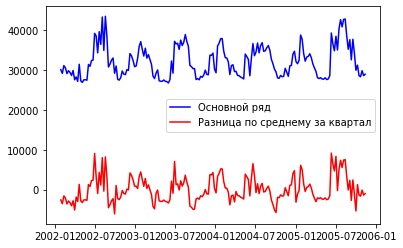

In [457]:
N100=200
plt.plot(data_per_week.index[1:N100],data_per_week['PJME_MW'][1:N100],'-b',label ='Основной ряд')
plt.plot(data_per_week.index[1:N100],data_per_week['diff_qarter_mean'][1:N100],'-r',label ='Разница по среднему за квартал')
plt.legend()
plt.show()

In [498]:
data_per_week.iloc[:12,14] = 0

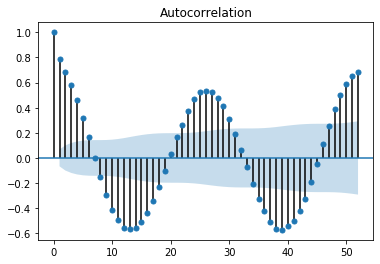

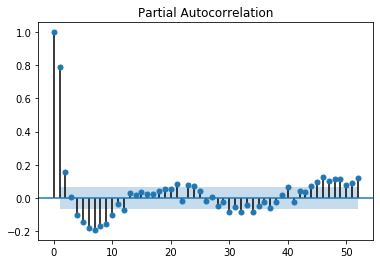

In [459]:
sm.graphics.tsa.plot_acf(data_per_week['PJME_MW'].values, lags=52)
plt.show()

#plt.subplot(2,1,2)
sm.graphics.tsa.plot_pacf(data_per_week['PJME_MW'].values, lags=52)
plt.show()

Сезонность данных - год, 52 недели.

In [460]:
p = 52
for i in range(p):
    data_per_week['t'+str(p-i)]=0
    data_per_week['t'+str(p-i)].values[p-i:] = data_per_week['PJME_MW'].values[:-p+i]

In [461]:
p = 52
for i in range(p):
    data_per_week['d'+str(p-i)]=0
    data_per_week['d'+str(p-i)].values[p-i:] = data_per_week['diff1'].values[:-p+i]

In [500]:
data_per_week.describe()

,PJME_MW,quarter,weekofyear,is_holiday,claster_week,pca1,pca2,pca3,diff1,diff2,...,d9,d8,d7,d6,d5,d4,d3,d2,d1,d_w13
count,864.000000,864.000000,864.000000,864.000000,864.000000,864.000000,864.000000,864.000000,864.000000,864.000000,...,864.000000,864.000000,864.000000,864.000000,864.000000,864.000000,864.000000,864.000000,864.000000,852.000000
mean,32082.259944,2.483796,26.273148,0.189815,2.981481,0.004531,-0.001182,0.002305,5.881270,10.730414,...,-0.630787,-3.327546,-1.358796,3.726852,5.115741,8.064815,5.704861,4.770833,5.892361,32075.057597
std,3986.930919,1.105015,14.997780,0.392382,1.758180,1.410921,1.008043,0.975508,2573.150082,3160.788654,...,2563.475316,2564.699931,2565.355277,2569.709686,2570.031940,2571.487547,2572.430419,2572.578996,2572.788125,2476.216735
min,24577.173653,1.000000,1.000000,0.000000,0.000000,-2.297114,-1.796047,-2.644891,-9574.619048,-12762.738095,...,-9574.000000,-9574.000000,-9574.000000,-9574.000000,-9574.000000,-9574.000000,-9574.000000,-9574.000000,-9574.000000,27143.547619
25%,28787.257440,2.000000,13.000000,0.000000,1.000000,-1.144889,-0.875822,-0.496938,-1469.269345,-1806.970238,...,-1429.500000,-1456.000000,-1456.000000,-1456.000000,-1456.000000,-1456.000000,-1469.000000,-1469.000000,-1469.000000,30080.129337
50%,31409.348214,2.000000,26.000000,0.000000,3.000000,-0.155194,-0.125728,0.039857,-45.869048,-79.083333,...,-36.500000,-41.500000,-41.500000,-41.500000,-41.500000,-41.500000,-45.000000,-45.500000,-45.500000,31808.581986
75%,34844.577381,3.000000,39.000000,0.000000,4.000000,1.099089,0.674014,0.667152,1286.818452,1706.788690,...,1272.250000,1272.250000,1276.250000,1277.500000,1277.500000,1286.000000,1286.000000,1286.000000,1286.000000,33771.151249
max,46761.494048,4.000000,53.000000,1.000000,6.000000,2.575888,3.375311,2.757890,10708.190476,11540.595238,...,10708.000000,10708.000000,10708.000000,10708.000000,10708.000000,10708.000000,10708.000000,10708.000000,10708.000000,38900.817766


## Выделение существенных признаков

Запишем итоговую систему признаков и проведем ее анализ. Горизонт прогнозирования h = 1 и h4 = 4, тогда target = y(t+h)=y(t+1)

In [463]:
scl_target=StandardScaler() 
# p = 7
h=1
h4=4
target = data_per_week['PJME_MW'].values[h+p:].reshape((data_per_week.shape[0]-h-p,1))
y = scl_target.fit_transform(target)

target4 = data_per_week['PJME_MW'].values[h4+p:].reshape((data_per_week.shape[0]-h4-p,1))
y4 = scl_target.fit_transform(target4)

y.shape

(811, 1)

In [464]:
scl_x=StandardScaler() 

X = data_per_week.iloc[p:-h,:].values
X = scl_x.fit_transform(X.astype('float64'))

X4 = data_per_week.iloc[p:-h4,:].values
X4 = scl_x.fit_transform(X4.astype('float64'))

X.shape

(811, 128)

In [465]:
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import SelectFromModel

from sklearn.ensemble import GradientBoostingRegressor

from sklearn.feature_selection import f_regression, mutual_info_regression

f_test, _ = f_regression(X, y.ravel())
f_test /= np.max(f_test)
for i in range(X.shape[1]):
    print("F-test={:.2f},  I={}".format(f_test[i],i))

F-test=0.98,  I=0
F-test=0.00,  I=1
F-test=0.00,  I=2
F-test=0.00,  I=3
F-test=0.00,  I=4
F-test=0.01,  I=5
F-test=0.40,  I=6
F-test=0.15,  I=7
F-test=0.02,  I=8
F-test=0.04,  I=9
F-test=0.02,  I=10
F-test=1.00,  I=11
F-test=0.04,  I=12
F-test=0.45,  I=13
F-test=0.21,  I=14
F-test=0.01,  I=15
F-test=0.01,  I=16
F-test=0.02,  I=17
F-test=0.02,  I=18
F-test=0.03,  I=19
F-test=0.04,  I=20
F-test=0.05,  I=21
F-test=0.07,  I=22
F-test=0.24,  I=23
F-test=0.55,  I=24
F-test=0.63,  I=25
F-test=0.51,  I=26
F-test=0.36,  I=27
F-test=0.22,  I=28
F-test=0.11,  I=29
F-test=0.04,  I=30
F-test=0.01,  I=31
F-test=0.00,  I=32
F-test=0.02,  I=33
F-test=0.07,  I=34
F-test=0.14,  I=35
F-test=0.22,  I=36
F-test=0.27,  I=37
F-test=0.32,  I=38
F-test=0.31,  I=39
F-test=0.24,  I=40
F-test=0.14,  I=41
F-test=0.08,  I=42
F-test=0.03,  I=43
F-test=0.00,  I=44
F-test=0.00,  I=45
F-test=0.02,  I=46
F-test=0.06,  I=47
F-test=0.13,  I=48
F-test=0.19,  I=49
F-test=0.25,  I=50
F-test=0.26,  I=51
F-test=0.24,  I=52
F-t

Посмотрим на лучшие признаки из выборки, полученные разными способами.

In [466]:
for i in [1, 6, 11, 13, 14, 24, 25, 26, 27, 28, 29, 30, 38, 39, 40, 41, 42, 52, 53, 54, 64, 65, 66, 67, 76, 77]:
    print(data_per_week.iloc[p:-h,:].columns[i])

quarter
pca2
diff1_l
diff_qarter_mean
d_w7
t52
t51
t50
t49
t48
t47
t46
t38
t37
t36
t35
t34
t24
t23
t22
t12
t11
t10
t9
d52
d51


In [467]:
sfk =SelectKBest(f_regression, k=15)
X_new1 =sfk.fit_transform(X, y.ravel())
X_new1.shape

(811, 15)

In [468]:
column_names = data_per_week.columns[sfk.get_support()]
column_names

Index(['PJME_MW', 'pca2', 'diff1_l', 'diff_qarter_mean', 't52', 't51', 't50',
       't49', 't39', 't38', 't37', 't12', 't11', 't2', 't1'],
      dtype='object')

In [469]:
X_new1[295:300,:]

array([[ 0.48865365,  0.0550498 ,  0.54641539, -0.39592119,  0.33488887,
        -0.22336674,  0.31338356,  0.27243041,  0.55756918,  0.70790314,
        -0.10836773,  0.29363009,  1.47209109,  0.45233534,  1.12606526],
       [-0.31424954, -0.56083577, -0.26611548, -1.35570971, -0.22236209,
         0.31399297,  0.2744059 , -0.13279551,  0.70722328, -0.10772629,
         0.61175376,  1.47244387,  0.96706038,  1.12797365,  0.49015153],
       [-0.6290486 , -0.80304426, -0.60792833, -1.73201975,  0.31514769,
         0.27502127, -0.13086179, -0.54151907, -0.10938928,  0.6119907 ,
        -0.22377661,  0.9671299 ,  1.83019918,  0.49178317, -0.31327976],
       [-0.86024552, -0.98699083, -0.86831978, -0.40777676,  0.27616511,
        -0.13018442, -0.53962748, -0.62496263,  0.61119523, -0.22307034,
         0.73015379,  1.83075283,  2.38084394, -0.31199777, -0.62847397],
       [-0.91544848, -1.03046076, -0.93173022, -0.47376624, -0.12915375,
        -0.53888758, -0.62307964, -0.62046567, 

Лучшее множество признаков отделено в X_new1. Проверим результат оценки признаков по процентному отбору и сохраним его в X_new2.

In [470]:
sfp=SelectPercentile(f_regression, percentile=10)
X_new2 = sfp.fit_transform(X, y.ravel())
X_new2.shape

(811, 13)

In [471]:
column_namesp = data_per_week.columns[sfp.get_support()]
column_namesp

Index(['PJME_MW', 'pca2', 'diff1_l', 'diff_qarter_mean', 't52', 't51', 't50',
       't49', 't38', 't37', 't12', 't2', 't1'],
      dtype='object')

Наконец, третий вариант - применим выделение признаков через построение модели. Помним, что модель должна уметь выбрать подмножество признаков или вернуть коэффициент их влиятельности. Это ограничивает выбор моделей. Возьмем как оценшик GradientBoostingRegressor и построим новое пространство в X_new3

In [472]:
gr_model = GradientBoostingRegressor(max_depth=5, random_state=40, n_estimators=100).fit(X, y.ravel())
sfm = SelectFromModel(gr_model,  max_features = 15)

sfm.fit(X, y.ravel())
X_new3 = sfm.transform(X)
X_new3.shape

(811, 11)

In [501]:
list_param_k =np.where(sfk.get_support())[0]
list_param_p =np.where(sfp.get_support())[0]
list_param_m =np.where(sfm.get_support())[0]

print('Номера признаков k лучших признаков : ',list_param_k)
print('Номера признаков лучших признаков по процентной форме: ',list_param_p)
print('Номера признаков для выбора по модели : ',list_param_m)

Номера признаков k лучших признаков :  [ 0  6 11 13 24 25 26 27 37 38 39 64 65 74 75]
Номера признаков лучших признаков по процентной форме:  [ 0  6 11 13 24 25 26 27 38 39 64 74 75]
Номера признаков для выбора по модели :  [ 0  7 11 24 25 26 27 28 40 54 65]


Пересечение выбора по отбору для модели и по количественным оценкам связи в признаке 0. Имеет смысл брать объединение выборов. Возьмем [0, 6, 11, 13, 25, 26, 27, 28, 29, 39, 40, 41, 42, 53, 56, 66, 67, 76, 77] признаки и перейдем к построению модели.

In [502]:
list_par = list(list_param_k.copy())
list_par.extend(list(list_param_p))
list_par.extend(list(list_param_m))
list_par = list(set(list_par))

In [475]:
X_new = X[:,list_par]

X_new4 = X4[:,list_par]

data_per_week.columns[list_par]

Index(['PJME_MW', 'pca2', 'pca3', 'diff1_l', 'diff_qarter_mean', 't52', 't51',
       't50', 't49', 't48', 't39', 't38', 't37', 't36', 't22', 't12', 't11',
       't2', 't1'],
      dtype='object')


## Разделение данных на тестовые и тренировочные 


In [476]:
# сделаем функцию
def split_data( data, split_date ):
    return data.loc[data.index.get_level_values('Date') <= split_date].copy(), \
           data.loc[data.index.get_level_values('Date') >  split_date].copy()

Для временного ряда "Потребление энергии" назначим датой разделения 1/06/2016

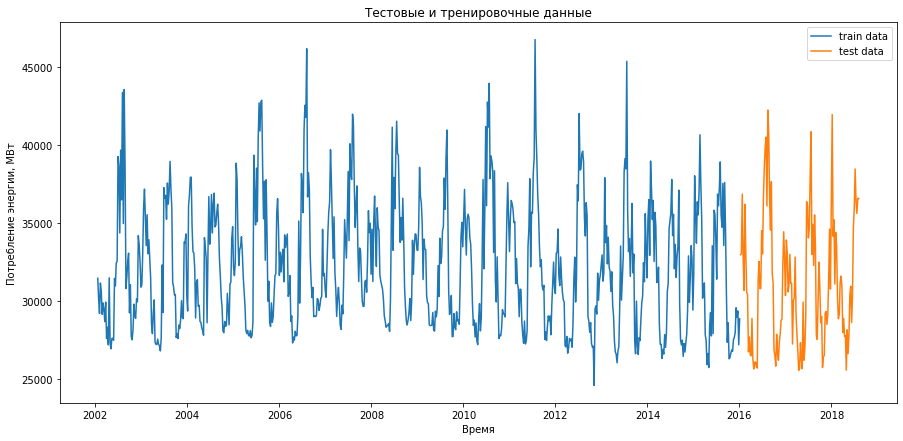

In [477]:
train, test = split_data(data_per_week, '01-06-2016')

plt.figure(figsize=(15, 7))
plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(train.index.get_level_values('Date'),train['PJME_MW'], label='train data' )
plt.plot(test.index.get_level_values('Date'),test['PJME_MW'], label='test data')
plt.title( 'Тестовые и тренировочные данные' )
plt.legend()
plt.show()

In [478]:
X_train =X_new[:train.shape[0],:]
y_train =y[:train.shape[0],0]
X_test =X_new[train.shape[0]:,:]
y_test =y[train.shape[0]:,0]

In [479]:
X_train4 =X_new4[:train.shape[0],:]
y_train4 =y4[:train.shape[0],0]
X_test4 =X_new4[train.shape[0]:,:]
y_test4 =y4[train.shape[0]:,0]

In [480]:
X_test[:,0]

array([ 0.45134378,  0.24932731, -0.38444307, -0.26454985,  0.22124482,
       -0.24504642, -0.24779357, -1.22351635, -0.52660032, -0.47416169,
        0.1773143 , -0.74911511, -1.06643127, -1.32488609, -1.64658664,
       -1.62544896, -1.20046507, -1.46957388, -1.62033259, -0.54801436,
       -1.48398186, -1.28853824, -0.78317441,  1.06838627,  1.00637743,
        0.48522382,  0.63624246,  1.47430143,  2.19427471,  0.22183489,
        0.70416537,  0.04161488,  0.85540659,  0.33617704, -1.07946343,
       -1.14970028, -0.50299334,  0.09578261, -0.32763425, -0.8819643 ,
       -0.77947569, -1.60151035, -1.42768094, -1.40787983, -0.72852715,
       -0.6995394 , -0.9064153 , -0.7498904 , -0.16612893,  0.62691499,
       -0.3379596 ,  1.15940826,  2.46999819,  0.51193647,  0.7761022 ,
       -0.2577604 ,  0.57393037,  0.36150789, -0.48474024, -0.81456423,
       -0.74511613, -0.231418  , -0.12935684, -0.29047376, -1.03859376,
       -0.81017985, -1.1019844 , -1.09139166, -1.64363334, -0.99

In [481]:
y_test

array([ 0.24910519, -0.38454826, -0.26467717,  0.22102788, -0.24517733,
       -0.24792398, -1.22346673, -0.52667928, -0.47425033,  0.17710546,
       -0.74915302, -1.06641063, -1.32481777, -1.64645896, -1.62532518,
       -1.20041971, -1.46947887, -1.62020976, -0.54808937, -1.48388419,
       -1.28847663, -0.78320603,  1.06801303,  1.00601563,  0.48495817,
        0.63594895,  1.47385329,  2.19369374,  0.22161783,  0.70385933,
        0.04143108,  0.85507265,  0.33593889, -1.07944039, -1.14966429,
       -0.50307666,  0.09558881, -0.32774992, -0.8819777 , -0.779508  ,
       -1.60139099, -1.42759366, -1.4077962 , -0.72856886, -0.69958646,
       -0.90642419, -0.74992817, -0.1662744 ,  0.6266232 , -0.33807336,
        1.15901822,  2.46936635,  0.5116659 ,  0.77578288, -0.25788897,
        0.57364836,  0.36126507, -0.48482693, -0.81459007, -0.74515477,
       -0.23155142, -0.12950909, -0.29059629, -1.03857827, -0.81020649,
       -1.1019572 , -1.09136642, -1.64350621, -0.99412713, -1.37

# Строим Модель

При решении задачи на начальном этапе, самый интересный результат был получен на модели GradientBoostingRegressor. Остановимся на построении иенно такой формы предсказания. Импортируем необходимые модели.

In [482]:
from sklearn.ensemble import GradientBoostingRegressor

In [483]:
model_g = GradientBoostingRegressor(max_depth=5, random_state=0, n_estimators=100)

Запускаем модели и смотрим , что они построят на наших примерах.

In [484]:
model_g.fit(X_train, y_train) # 

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=0, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [485]:
model_g4 = GradientBoostingRegressor(max_depth=5, random_state=0, n_estimators=100)
model_g4.fit(X_train, y_train) #

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=0, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

**Посмотрим тесты**

In [486]:
X_test.shape

(82, 19)

In [487]:
y_test_pred_g = model_g.predict(X_test)

In [488]:
y_test_pred_g4 = model_g4.predict(X_test4)

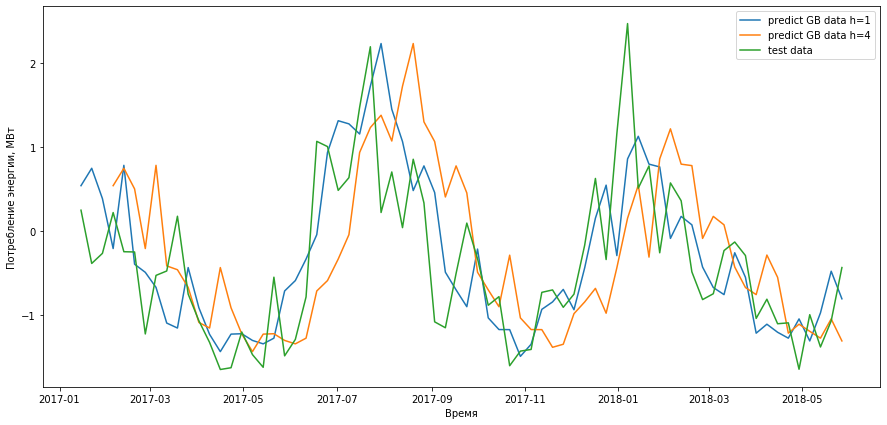

In [496]:
plt.figure( figsize=( 15, 7 ))

G = 10
plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(test.index[h+p:-G],y_test_pred_g[:-G], label='predict GB data h=1' )
plt.plot(test.index[h4+p:-G],y_test_pred_g4[:-G], label='predict GB data h=4' )
plt.plot(test.index[h+p:-G],y_test[:-G], label='test data')

plt.legend()
plt.show()

**Оценки для сравнения моделей**

In [253]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [254]:
er_s = mean_squared_error(y_true=y_test, y_pred=y_test_pred_g) 
er_a = mean_absolute_error(y_true=y_test, y_pred=y_test_pred_g) 
er_r2 = r2_score(y_true=y_test, y_pred=y_test_pred_g)

print('ошибка mse :  ', er_s,'\nошибка mae  :  ', er_a,'\nоценка R2 :  ', er_r2)

ошибка mse :   0.3586630744508535 
ошибка mae  :   0.4657756542194434 
оценка R2 :   0.5947163742294465


In [255]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [256]:
er_g = mean_absolute_percentage_error(y_true=scl_target.inverse_transform( y_test),y_pred = scl_target.inverse_transform( y_test_pred_g))

print('ошибка градиентного бустинга MAPE :  ', er_g,'%')

ошибка градиентного бустинга MAPE :   5.885636096772375 %


Ошибка неплоха, но мы имеем дело с маленьким горизонтом прогноза и тем неменее пока точность предсказания не превышает 95%. 
Построим более точную модель с использованием поиска моделей. Воспользуемся методом поиска 

In [239]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [243]:
from sklearn.model_selection import GridSearchCV


def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

param_dist = {"max_depth": [3, 2,1,4,5,6,7,8,9,10], 
              "n_estimators":[100,200,300,400,500,600,700,800,900], 
             'learning_rate':[0.1, 0.01, 0.05, 0.2]}

#  randomized search
n_iter = 20

model_gr =GradientBoostingRegressor(random_state=0)

random_search = GridSearchCV(model_gr, param_grid=param_dist, cv=5, iid=False, n_jobs=-1)

random_search.fit(X_train, y_train)

report(random_search.cv_results_)

Model with rank: 1
Mean validation score: 0.707 (std: 0.024)
Parameters: {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 400}

Model with rank: 2
Mean validation score: 0.705 (std: 0.024)
Parameters: {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 300}

Model with rank: 3
Mean validation score: 0.705 (std: 0.024)
Parameters: {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 500}



Выбираем модель с рангом 1. {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 400} и проведем ее обучение на тренировочном наборе.

In [278]:
model_g_best = GradientBoostingRegressor(max_depth=4, learning_rate=0.01, n_estimators=400, random_state=0)
model_g_best.fit( X_train, y_train ) 
y_test_pred_xg = model_g_best.predict(X_test)

er_xg = mean_absolute_percentage_error(y_true=scl_target.inverse_transform( y_test),
                                      y_pred = scl_target.inverse_transform( y_test_pred_xg))
print('ошибка градиентного бустинга MAPE :  ', er_xg,'%')

ошибка градиентного бустинга MAPE :   6.018941229844802 %


Как ни странно, подбор параметров показал результаты худше. Так же запускался тест на сторонних библиотеках XGBoost и LightBoost, результаты там тоже были не лучше.

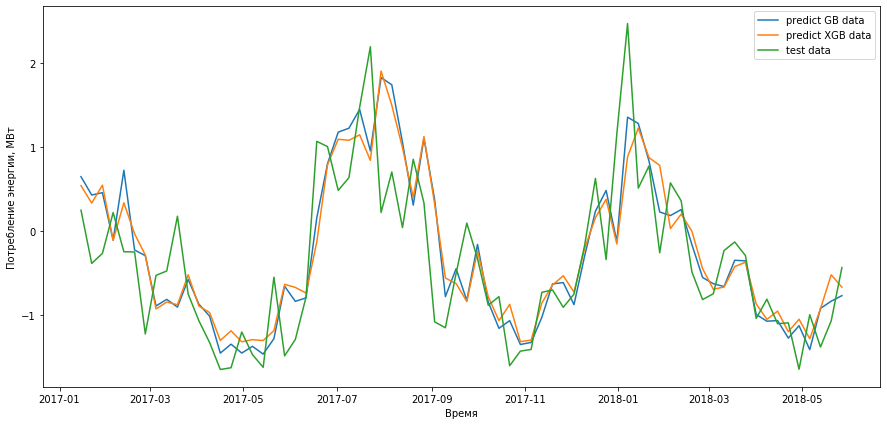

In [279]:
plt.figure( figsize=( 15, 7 ))

G = 10
plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(test.index[h+p:-G],y_test_pred_g[:-G], label='predict GB data' )
plt.plot(test.index[h+p:-G],y_test_pred_xg[:-G], label='predict XGB data' )
plt.plot(test.index[h+p:-G],y_test[:-G], label='test data')

plt.legend()
plt.show()

## Использование модели для предсказания n*h моментов времени

Мы построили короткий прогноз, но его можно продолжить на следующие точки ряда. Для этого будем использовать результаты прогноза для следующего шага.  Необходимо заменять X_test[t+i, 0] = y_test[t+i-1] и продолжить моделирование в новом состоянии. Сделаем 80 дней прогноза с ипсользованием рекурсивного подхода.

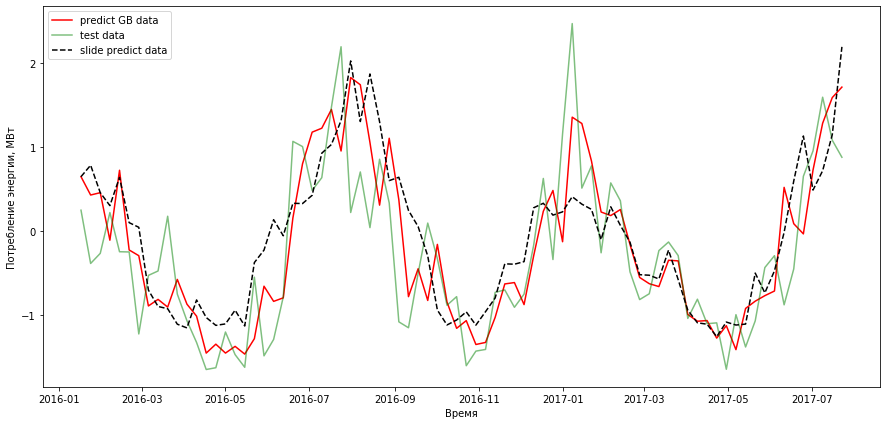

In [419]:
# ['PJME_MW', 'pca2', 'diff1_l', 'diff_qarter_mean', 't53', 't52', 't51',
#        't50', 't49', 't39', 't38', 't37', 't36', 't25', 't22', 't12', 't11', 't2', 't1']
X_test_ftr = X_test.copy()
y_test_ftr = y_test_pred_g.copy()
N100 = 80


for i in range(N100):
    y_test_pred = model_g.predict(X_test_ftr[i,:].reshape((1, 19)))
        
    i_main = X_train.shape[0]+i+1
    
    temp_obj = data_per_week.iloc[:,:4]
    
    temp_obj.iloc[i_main,:].PJME_MW = scl_target.inverse_transform(y_test_pred)
    
    X_temp = temp_obj.values
    Xscale_temp = scl.fit_transform(X_temp)
    
    
    Xpca = pca.transform(Xscale_temp[:,:])
    
    temp_obj['pca2']=Xpca[:,1]
    
    temp_obj['diff1_l'] = np.log(temp_obj.PJME_MW.values)
    
    temp_obj['diff_qarter_mean'] = data_per_week['diff_qarter_mean']
    temp_obj_quarter = temp_obj.iloc[i_main].quarter
    mean_for_quarter = temp_obj.loc[temp_obj.quarter==temp_obj_quarter, 'PJME_MW'].values.mean()
    
    temp_obj.loc[temp_obj.quarter == temp_obj_quarter, 'diff_qarter_mean']= \
    temp_obj.loc[temp_obj.quarter == temp_obj_quarter, 'PJME_MW']-mean_for_quarter
    
    t_temp = [1, 2, 11, 12, 22, 25, 36, 37, 38, 39, 49, 50, 51, 52, 53]
    for i_t in t_temp[::-1]:
        
        temp_obj['t'+str(i_t)]=data_per_week['t'+str(i_t)]
        temp_obj['t'+str(i_t)].values[i_main] = temp_obj['PJME_MW'].values[i_main-i_t]
    
    temp_obj.drop(['quarter', 'weekofyear', 'is_holiday'], axis=1,inplace=True)
    
    scl_temp = StandardScaler()
    temp_obj = scl_temp.fit_transform(temp_obj.values.astype('float'))[i_main+1]
    
    X_test_ftr[i+1] = temp_obj
    y_test_ftr[i] = y_test_pred
    
plt.figure( figsize=( 15, 7 ))


plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(test.index[1:N100+1],y_test_pred_g[:N100], 'r',label='predict GB data' )
plt.plot(test.index[1:N100+1],y_test[:N100], 'g',label='test data', alpha=0.5)
plt.plot(test.index[1:N100+1],y_test_ftr[:N100], '--k',label='slide predict data')

plt.legend()
plt.show()    

Ошибка прогнозирования упала, что и ожидаемо для прогнозирования на более длительный период.

In [420]:
er_g_ftr = mean_absolute_percentage_error(y_true=scl_target.inverse_transform(y_test[:N100]),y_pred = scl_target.inverse_transform(y_test_ftr[:N100]))
print('ошибка градиентного бустинга MAPE :  ', er_g_ftr,'%')

ошибка градиентного бустинга MAPE :   7.134431706997059 %


Посмотрим на ошибку с разбивкой по 10 дней. Видим, что ошибка в некоторые периоды возрастает значительно(более 10%), а в некоторые периоды снижается до почти 3%, что говорит о нестабльности предсказания.

In [424]:
for j in [0, 10, 20, 30, 40, 50, 60, 70]:
    er_100j = mean_absolute_percentage_error(y_true=scl_target.inverse_transform(y_test[j:j+10]),y_pred = scl_target.inverse_transform(y_test_ftr[j:j+10]))

    print('ошибка рекурсивной модели на отрезке',j,':',j+10,'  MAPE :  ', er_100j,'%')

ошибка рекурсивной модели на отрезке 0 : 10   MAPE :   8.591028302777369 %
ошибка рекурсивной модели на отрезке 10 : 20   MAPE :   6.964794621529208 %
ошибка рекурсивной модели на отрезке 20 : 30   MAPE :   9.250877012518664 %
ошибка рекурсивной модели на отрезке 30 : 40   MAPE :   10.279378646231976 %
ошибка рекурсивной модели на отрезке 40 : 50   MAPE :   5.4809916376637755 %
ошибка рекурсивной модели на отрезке 50 : 60   MAPE :   5.828314890699422 %
ошибка рекурсивной модели на отрезке 60 : 70   MAPE :   3.149614792448427 %
ошибка рекурсивной модели на отрезке 70 : 80   MAPE :   7.530453752107623 %
